In [23]:
# To visualize the Fast R-CNN network
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from utils.cython_nms import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
import dlib
import caffe, os, sys, cv2
%matplotlib inline

prototxt = '/home/isit/workspace/fast-rcnn/models/DefoObject/test.prototxt'
#caffemodel = '/home/isit/workspace/fast-rcnn/output/default/train/CaffeNet.v2.caffemodel'
caffemodel = '/home/isit/workspace/fast-rcnn/output/default/train/defo_obj_fast_rcnn_iter_80000.caffemodel'
# caffemodel = '/home/isit/workspace/DefoObjInWild/results_final/simple/defo_obj_fast_rcnn_iter_50000.caffemodel'

net = caffe.Net(prototxt, caffemodel, caffe.TEST)

In [11]:
# Function to visualize first conv layer's weights as images
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')
    plt.savefig('img_cond_50000.png', bbox_inches='tight')

blobs ['data', 'rois', 'conv1', 'pool1', 'norm1', 'conv2', 'pool2', 'norm2', 'conv3', 'conv4', 'conv5', 'pool5', 'fc6', 'fc7', 'fc7_drop7_0_split_0', 'fc7_drop7_0_split_1', 'cls_score_do', 'bbox_pred_do', 'cls_prob']
params ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'cls_score_do', 'bbox_pred_do']
(96, 3, 11, 11)
('First filter shape is', (96, 11, 11, 3))
('Prob shape is: ', (8, 4096))
('Second Filter shape is', (256, 192, 3, 3))


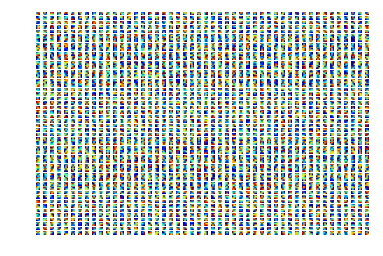

In [28]:
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

# for the first layer
filters = net.params['conv1'][0].data
print filters.shape
[m,n,fm,fn] = filters.shape
filters = filters.transpose(0, 2, 3, 1)
print ("First filter shape is", filters.shape)
# vis_square(filters)

probs = net.params['bbox_pred_do'][0].data
print ("Prob shape is: ", probs.shape)
# for the second layer
second_filters = net.params['conv5'][0].data
[m,n,fm,fn] = second_filters.shape
print ("Second Filter shape is", second_filters.shape)
k = 1
filters = (filters - filters.min()) / (filters.max() - filters.min())
for i in range(50):
    for j in range(48):
        img = second_filters[i,j,:,:]
        plt.subplot(50,48,k)
        k += 1
        plt.imshow(img); plt.axis('off')
plt.savefig('weights/conv5_80000.png', bbox_inches='tight')

In [19]:
# visualize an image being put through the network

# net1 = caffe.Net(prototxt, caffe.TEST)
# print "\nnet.inputs =", net1.inputs
# print "\ndir(net.blobs) =", dir(net1.blobs)
# print "\ndir(net.params) =", dir(net1.params)
# print "\nconv shape = ", net1.blobs['conv1'].data.shape

# im = cv2.imread('/home/isit/workspace/DefoObjInWild/dataset/Images/object0_img5_fv_easy_1.jpg', 0)
# img_blobinp = img[np.newaxis, np.newaxis, :, :]
# net1.blobs['data'].reshape(*img_blobinp.shape)
# net1.blobs['data'].data[...] = img_blobinp

net.forward()

# for i in range(10):
#     cv2.imwrite('output_image_' + str(i) + '.jpg', 255*net1.blobs['conv2'].data[0,i])


{'bbox_pred_do': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00385897,
         -0.00786276,  0.00789434,  0.04628552]], dtype=float32),
 'cls_prob': array([[ 0.59681267,  0.40318733]], dtype=float32)}

ValueError: num must be 1 <= num <= 4, not 5

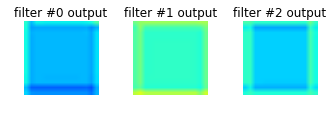

In [21]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv5'].data.min(), net.blobs['conv4'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv4'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

In [11]:
# pick first filter output
conv0 = net.blobs['conv2'].data[0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean 0.97
post-surgery output mean 0.97
